## Theory

### Quantization of real values
If raw input stored as a sequence of 16-bit integer values (one per timestep), a softmax layer would need to output 65,536 probabilities per timestep to model all possible values. Therefore a µ-law companding transformation (ITU-T, 1988) is applied to the data and then quantizied to 256 possible values

$$
f(x_t) = \text{sgn}(x_t) {\log(1 + \mu|x_t|) \over \log( 1 + \mu )} \\
$$

### Unconditional
$$
p(x) = \prod^T_{t=1} p \left( x_t | x_1, \dots , x_{t-1} \right) \\
z = \tanh \left( W_{f,k} ∗ x \right) \odot \sigma \left(W_{g,k} ∗ x \right)
$$

### Conditional
$$
p(x | h) = \prod^T_{t=1} p \left( x_t | x_1, \dots , x_{t-1}, h \right) \\
$$

#### global conditioning
- characterised by a single latent representation $h$ that influences the output distribution across all timesteps, e.g. a speaker embedding in a TTS model
$$
z = \tanh \left( W_{f,k} ∗ x + V^T_{f,k} h \right) \odot \sigma \left( W_{g,k} ∗ x + V^T_{g,k} h \right) \\
$$
- the vector $V^T_{∗,k}h$ is broadcast over the time dimension

#### local conditioning
- using a second timeseries $h_t$, possibly with a lower sampling frequency than the raw input signal, e.g. linguistic features in a TTS model
- $h_t$ is first transformed by a transposed convolutional network (learned upsampling) mapping it to $y = f(h)$ with the same resolution as the input

$$
z = \tanh \left( W_{f,k} ∗ x + V_{f,k} ∗ y \right) \odot \sigma \left( W_{g,k} ∗ x + V_{g,k} * y \right)
$$
- $V_{f,k} ∗y$ is now a 1×1 convolution

### Context
We have already mentioned several ways to increase the receptive field size of a WaveNet: increasing
the number of dilation stages, using more layers, larger filters, greater dilation factors, or a
combination thereof. A complementary approach is to use a separate, smaller context stack that
processes a long part of the audio signal and locally conditions a larger WaveNet that processes
only a smaller part of the audio signal (cropped at the end). One can use multiple context stacks
with varying lengths and numbers of hidden units. Stacks with larger receptive fields have fewer
units per layer. Context stacks can also have pooling layers to run at a lower frequency. This keeps
the computational requirements at a reasonable level and is consistent with the intuition that less
capacity is required to model temporal correlations at longer timescales.

In [97]:
from PIL import Image

### Causal convolution

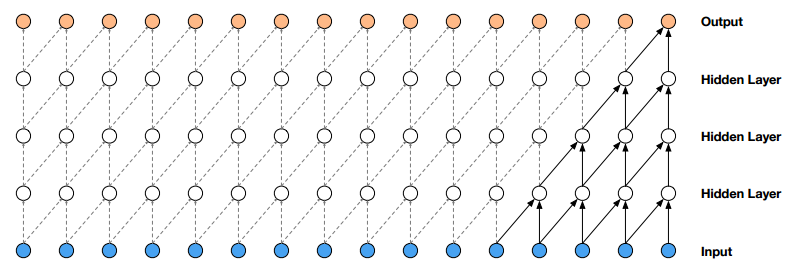

In [99]:
Image.open('./causal.png')

### Causal dilated convolution

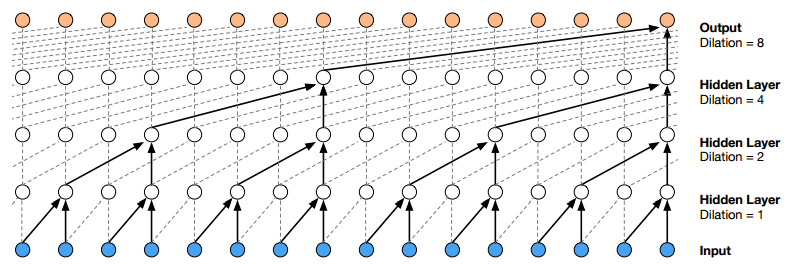

In [101]:
Image.open('./causal_dilated.png')

### Wavenet block

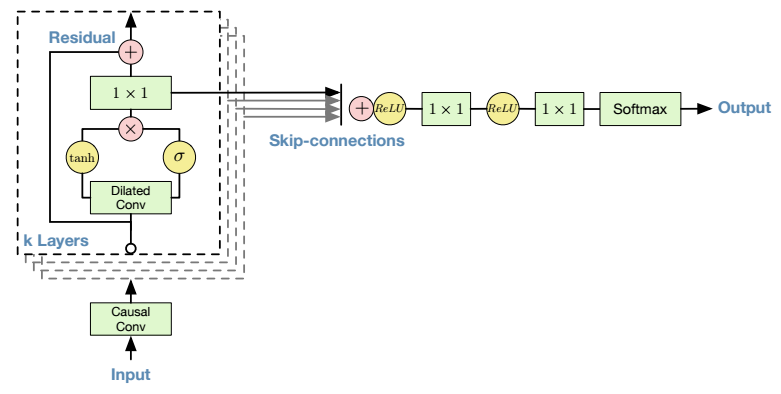

In [98]:
Image.open('./wavenet.png')

## Implementation

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

def mu_law(x, mu, module=T):
    return module.sign(x) * module.log(1 + mu * module.abs(x)) / module.log(1 + mu)

Using gpu device 0: GeForce GTX 970M (CNMeM is disabled, cuDNN 5005)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

In [26]:
# global
latent = lasagne.layers.InputLayer((None, 120), name='latent')
# local
latent = lasagne.layers.InputLayer((None, 120, 1, 5), name='latent')

In [30]:
[(64, 2)] + [(2, 2**i) for i in range(5)]

[(64, 2), (2, 1), (2, 2), (2, 4), (2, 8), (2, 16)]

In [32]:
import wavenet
reload(wavenet)
from wavenet import build_wavenet
specs = [(2, (1,2)), (2, (1,2), (1,1)), (2, (1,2), (1,2)), (2, (1,2), (1,4)), (2, (1,2), (1,8))]
specs = [(64, 2)] + [(2, 2**i) for i in range(4)]

wavenet, out_l = build_wavenet(1, 16, specs, latent=latent)

((None, 64, 1, 16), (None, 64, 1, 16))
(None, 64, 1, 16)
[(None, 64, 1, 16), (None, 64, 1, 16)]
((None, 64, 1, 16), (None, 64, 1, 16))
(None, 64, 1, 16)
[(None, 64, 1, 16), (None, 64, 1, 16)]


In [20]:
import theano
import lasagne
import numpy as np

In [33]:
import wavenet
reload(wavenet)
from wavenet import build_wavenet
specs = [(64, 2), (2, 1), (2, 2), (2, 4), (2, 8)]
# specs = [(64, 3), (3, 1), (3, 2), (3, 4), (3, 8)]
wavenet, out_l = build_wavenet(256, None, specs)
[x.output_shape for x in wavenet.values()]

(None, 64, 1, None)
[(None, 64, 1, None), (None, 64, 1, None)]
(None, 64, 1, None)
[(None, 64, 1, None), (None, 64, 1, None)]


[(None, None, 256),
 (None, 256, 1, None),
 (None, 64, 1, None),
 (None, 64, 1, None),
 (None, 32, 1, None),
 (None, 32, 1, None),
 (None, 32, 1, None),
 (None, 64, 1, None),
 (None, 64, 1, None),
 (None, 64, 1, None),
 (None, 32, 1, None),
 (None, 32, 1, None),
 (None, 32, 1, None),
 (None, 64, 1, None),
 (None, 64, 1, None),
 (None, 64, 1, None),
 (None, 64, 1, None),
 (None, 256, 1, None),
 (None, None, 256, 1),
 (None, None, None)]

In [8]:
[(k, v.output_shape) for k, v in wavenet.items()]

[('input', (None, None, 256)),
 ('input_dimshfl', (None, 256, 1, None)),
 ('causal_conv_0', (None, 64, 1, None)),
 ('dil_causal_conv_1', (None, 64, 1, None)),
 ('tanh_slice_1', (None, 32, 1, None)),
 ('sigmoid_slice_1', (None, 32, 1, None)),
 ('prod_merge_1', (None, 32, 1, None)),
 ('full_conv_1', (None, 64, 1, None)),
 ('res_out_1', (None, 64, 1, None)),
 ('dil_causal_conv_2', (None, 64, 1, None)),
 ('tanh_slice_2', (None, 32, 1, None)),
 ('sigmoid_slice_2', (None, 32, 1, None)),
 ('prod_merge_2', (None, 32, 1, None)),
 ('full_conv_2', (None, 64, 1, None)),
 ('res_out_2', (None, 64, 1, None)),
 ('skip_merge', (None, 64, 1, None)),
 ('pre_out', (None, 64, 1, None)),
 ('output', (None, 256, 1, None)),
 ('output_dimshfl', (None, None, 256, 1)),
 ('output_reshape', (None, None, None))]

In [4]:
get_out_fn = theano.function([wavenet['input'].input_var],
                             lasagne.layers.get_output(out_l))

In [47]:
get_out_fn(np.random.rand(1, 36, 256).astype('float32')).shape

AttributeError: 'list' object has no attribute 'shape'

In [37]:
outputs = [wavenet['causal_conv_0'], wavenet['dil_causal_conv_1'], wavenet['dil_causal_conv_2'], wavenet['output']]

In [38]:
get_out_fn = theano.function([wavenet['input'].input_var],
                             lasagne.layers.get_output(outputs))

In [50]:
res = get_out_fn(np.random.rand(1, 16, 256).astype('float32'))

In [51]:
[x.shape for x in res]

[(1, 64, 1, 16), (1, 64, 1, 16), (1, 64, 1, 16), (1, 256, 1, 16)]

In [54]:
np.concatenate(res[:-1], -2)[0,0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.35206056,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.2473066 ,
         0.        ,  0.14217132,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.01247583,  0.        ,  0.        ,
         0.09866312,  0.        ,  0.        ,  0.12913263,  0.        ,
         0.        ,  0.        ,  0.00667533,  0.        ,  0.21035333,
         0.02233015]], dtype=float32)

In [15]:
# get_out_fn = theano.function([wavenet['input'].input_var, latent.input_var],
#                              lasagne.layers.get_output(out_l))

In [33]:
# get_out_fn(np.ones((1,1,1,16)).astype('float32')).shape # uncoditional
# get_out_fn(np.ones((1,1,1,16)).astype('float32'), np.ones((1,120)).astype('float32')).shape # global conditional
get_out_fn(np.ones((1,1,1,16)).astype('float32'), np.ones((1,120,2,5)).astype('float32')).shape # local conditional

(1, 256, 1, 16)

## all wavenets working!! -> training loop 

#### Dilated causal convolution

In [115]:
net = OrderedDict()
net['inp'] = InputLayer((None, 1, 1, 16), name='input')

net['dil1'] = dilate(net.values()[-1], num_filters=1, filter_size=(1,2), dilation=(1,1),
                     nonlinearity=linear, W=lasagne.init.Constant(1.), name='dil_conv1')
net['pad1'] = pad(net.values()[-1], width=[(1,0)], val=0, batch_ndim=3, name='pad2')

net['dil2'] = dilate(net.values()[-1], num_filters=1, filter_size=(1,2), dilation=(1,2),
                     nonlinearity=linear, W=lasagne.init.Constant(1.), name='dil_conv2')
net['pad2'] = pad(net.values()[-1], width=[(2,0)], val=0, batch_ndim=3, name='pad2')

net['dil4'] = dilate(net.values()[-1], num_filters=1, filter_size=(1,2), dilation=(1,4),
                     nonlinearity=linear, W=lasagne.init.Constant(1.), name='dil_conv4')
net['pad4'] = pad(net.values()[-1], width=[(4,0)], val=0, batch_ndim=3, name='pad4')

net['dil8'] = dilate(net.values()[-1], num_filters=1, filter_size=(1,2), dilation=(1,8),
                     nonlinearity=linear, W=lasagne.init.Constant(1.), name='dil_conv8')
net['pad8'] = pad(net.values()[-1], width=[(8,0)], val=0, batch_ndim=3, name='pad8')

In [116]:
net['dil8'].W.get_value(borrow=True)

array([[[[ 1.,  1.]]]], dtype=float32)

In [117]:
[(x.name, x.output_shape) for x in net.values()]

[('input', (None, 1, 1, 16)),
 ('dil_conv1', (None, 1, 1, 15)),
 ('pad2', (None, 1, 1, 16)),
 ('dil_conv2', (None, 1, 1, 14)),
 ('pad2', (None, 1, 1, 16)),
 ('dil_conv4', (None, 1, 1, 12)),
 ('pad4', (None, 1, 1, 16)),
 ('dil_conv8', (None, 1, 1, 8)),
 ('pad8', (None, 1, 1, 16))]

In [118]:
get1_fn = theano.function([net['inp'].input_var], lasagne.layers.get_output(net['pad1']), allow_input_downcast=True)
get2_fn = theano.function([net['inp'].input_var], lasagne.layers.get_output(net['pad2']), allow_input_downcast=True)

In [119]:
get1_fn(np.ones((1,1,1,16)))

array([[[[ 0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
           2.,  2.,  2.]]]], dtype=float32)

In [120]:
get2_fn(np.ones((1,1,1,16)))

array([[[[ 0.,  0.,  2.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
           4.,  4.,  4.]]]], dtype=float32)

In [94]:
get1_fn(np.ones((1,1,1,16))).shape, get2_fn(np.ones((1,1,1,16))).shape

((1, 1, 1, 16), (1, 1, 1, 16))

In [ ]:
# np.random.seed(123)
# sb.regplot(x=np.arange(trainX.shape[0]), y=binarize(trainX.squeeze()))

# np.random.seed(123)
# sb.regplot(x=np.arange(trainX.shape[0]), y=np.random.binomial(n=1, p=trainX.squeeze()))